# Classification Analysis of Fine-Tuned Model Generations

This notebook processes the generated text from fine-tuned models (Gemma-3-4B and Qwen3-4B) and classifies each generation using an API endpoint. The classification determines whether the text is 'Técnico' (Technical) or 'Plano' (Plain language).

## Workflow:
1. Read the CSV files with model generations
2. Extract values from `generated_text` column from both models
3. Send POST requests to the classification API
4. Collect predictions and save to a new CSV file
5. Perform data analysis and create visualizations

In [18]:
# Import required libraries
import pandas as pd
import numpy as np
import requests
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Step 1: Load and Explore the Data

First, let's read the CSV file and examine its structure to understand what data we're working with.

In [ ]:
# Define the CSV file paths
csv_file_paths = {
    'gemma': "eval_google__gemma-3-4b-it_Grade13_20251121-042315.csv",
    'qwen': "eval_Qwen__Qwen3-4B-Instruct-2507_Grade8_20251119-224814.csv",
    'commercial': "commercial_models_results_test_200examples_classification_merged_long.csv",
    'ollama': "GENERATED_TEXTS/ollama__outputs__meta-llama__Llama-3.2-3B-Instruct-FKGD9_Sliding_Window__final_generations.csv"
}

# Read all CSV files
dataframes = {}
try:
    for model_name, file_path in csv_file_paths.items():
        df = pd.read_csv(file_path)
        dataframes[model_name] = df
        print(f"✅ Successfully loaded {model_name} CSV file")
        print(f"📊 Data shape: {df.shape}")
        print(f"📋 Columns: {list(df.columns)}")
        
        # Display model identifier based on file type
        if model_name == 'commercial':
            unique_models = df['model'].unique() if 'model' in df.columns else ['N/A']
            print(f"📝 Models in file: {list(unique_models)}")
        elif model_name == 'ollama':
            print(f"📝 Model identifier: meta-llama/Llama-3.2-3B-Instruct")
            print(f"📝 Generations per sample: 4 (gen_1, gen_2, gen_3, gen_4)")
        else:
            print(f"📝 Model identifier: {df['model'].iloc[0] if 'model' in df.columns else 'N/A'}")
        print("-" * 80)
    
    # Display first few rows from each
    print("\n🔍 First 3 rows from Gemma dataset:")
    display(dataframes['gemma'].head(3))
    
    print("\n🔍 First 3 rows from Qwen dataset:")
    display(dataframes['qwen'].head(3))
    
    print("\n🔍 First 3 rows from Commercial models dataset:")
    display(dataframes['commercial'].head(3))
    
    print("\n🔍 First 3 rows from Ollama dataset:")
    display(dataframes['ollama'].head(3))
    
    # Check for missing values
    print("\n❓ Missing values in Gemma dataset:")
    print(dataframes['gemma'].isnull().sum())
    
    print("\n❓ Missing values in Qwen dataset:")
    print(dataframes['qwen'].isnull().sum())
    
    print("\n❓ Missing values in Commercial models dataset:")
    print(dataframes['commercial'].isnull().sum())
    
    print("\n❓ Missing values in Ollama dataset:")
    print(dataframes['ollama'].isnull().sum())
    
except FileNotFoundError as e:
    print(f"❌ Error: File not found - {e}")
    print("📁 Current working directory files:")
    import os
    print([f for f in os.listdir('.') if f.endswith('.csv')])
except Exception as e:
    print(f"❌ Error loading file: {e}")

✅ Successfully loaded gemma CSV file
📊 Data shape: (30, 13)
📋 Columns: ['model', 'run_timestamp', 'doc_key', 'original_text', 'generated_text', 'relevance', 'factuality', 'gen_word_count', 'gen_sentence_count', 'gen_Flesch_Kincaid_Grade', 'gen_SMOG_Index', 'gen_Dale_Chall_Index', 'target_fk_grade']
📝 Model identifier: google/gemma-3-4b-it
--------------------------------------------------------------------------------
✅ Successfully loaded qwen CSV file
📊 Data shape: (30, 22)
📋 Columns: ['model', 'run_timestamp', 'doc_key', 'original_text', 'generated_text', 'relevance', 'factuality', 'gen_word_count', 'gen_sentence_count', 'gen_character_count', 'gen_characters_per_word', 'gen_words_per_sentence', 'gen_FRE', 'gen_Flesch_Kincaid_Grade', 'gen_SMOG_Index', 'gen_Gunning_Fog_Index', 'gen_Coleman_Liau_Index', 'gen_ARI', 'gen_LIX', 'gen_RIX', 'gen_Dale_Chall_Index', 'target_fk_grade']
📝 Model identifier: Qwen/Qwen3-4B-Instruct-2507
------------------------------------------------------------

,model,run_timestamp,doc_key,original_text,generated_text,relevance,factuality,gen_word_count,gen_sentence_count,gen_Flesch_Kincaid_Grade,gen_SMOG_Index,gen_Dale_Chall_Index,target_fk_grade
0,google/gemma-3-4b-it,20251121-042315,00352b568813412b386c93bc2351ac9d32ac5c98,Background\r\nAlzheimer's disease and other fo...,Here’s a plain-language summary of the clinica...,0.835028,0.630684,319,17,12.118315,14.126518,10.887356,13
1,google/gemma-3-4b-it,20251121-042315,0382f2eee8d97b6025a5f240bdb18ff742853707,Background\r\nTuberculous pericarditis can imp...,Here’s a plain-language summary of the clinica...,0.821820,0.732671,335,18,10.197099,12.945023,10.622950,13
2,google/gemma-3-4b-it,20251121-042315,0505032fa6e7ae8227d049f95cd9903323cf429f,"Background\r\nWater, sanitation and hygiene (W...",Here’s a plain-language summary of the clinica...,0.825477,0.658471,351,21,9.958149,12.704596,10.461185,13



🔍 First 3 rows from Qwen dataset:


,model,run_timestamp,doc_key,original_text,generated_text,relevance,factuality,gen_word_count,gen_sentence_count,gen_character_count,...,gen_FRE,gen_Flesch_Kincaid_Grade,gen_SMOG_Index,gen_Gunning_Fog_Index,gen_Coleman_Liau_Index,gen_ARI,gen_LIX,gen_RIX,gen_Dale_Chall_Index,target_fk_grade
0,Qwen/Qwen3-4B-Instruct-2507,20251119-224814,00352b568813412b386c93bc2351ac9d32ac5c98,Background\r\nAlzheimer's disease and other fo...,The Mini-Cog is a short test used to check for...,0.845604,NaN,241,13,1105,...,59.538793,9.560332,12.230962,12.892563,9.295104,9.434874,41.360038,4.230769,9.404389,8
1,Qwen/Qwen3-4B-Instruct-2507,20251119-224814,0382f2eee8d97b6025a5f240bdb18ff742853707,Background\r\nTuberculous pericarditis can imp...,"; 575 participants, 3 trials, low certainty ev...",0.835524,NaN,276,48,1573,...,49.883533,7.730036,9.299571,10.415942,11.349565,8.288587,32.561594,1.541667,12.195023,8
2,Qwen/Qwen3-4B-Instruct-2507,20251119-224814,0505032fa6e7ae8227d049f95cd9903323cf429f,"Background\r\nWater, sanitation and hygiene (W...",of a small positive effect of WASH interventio...,0.860033,NaN,390,32,2102,...,49.126226,9.434920,11.816420,12.464744,13.086051,10.049442,43.469551,3.812500,10.968171,8



🔍 First 3 rows from Commercial models dataset:


,row_index,model_key,model,prediction_label,prediction_int,generated_text,text_length,source_text,target_text,file_origin
0,0,generated_claude-sonnet-4-5,Claude 4.5 Sonnet,Plano,0,# Plain Language Summary: Local Anesthetic Ner...,1706,Background\nThis review is an update of a prev...,Local anaesthetic sympathetic blockade for com...,commercial_models_results_test_200examples_cla...
1,0,generated_chatgpt-5,GPT-5,Plano,0,Plain-language summary\n\nPurpose\n- To see if...,1849,Background\nThis review is an update of a prev...,Local anaesthetic sympathetic blockade for com...,commercial_models_results_test_200examples_cla...
2,1,generated_claude-sonnet-4-5,Claude 4.5 Sonnet,Plano,0,# Plain Language Summary: Anti-Angiogenic Drug...,2028,Background\nThis is an updated version of the ...,Drugs that target blood vessels in malignant b...,commercial_models_results_test_200examples_cla...



🔍 First 3 rows from Ollama dataset:


,source_text,gen_1,gen_2,gen_3,gen_4
0,Background\nBeta‐blockers are an essential par...,Beta blockers in children\nBeta blockers are m...,Beta‐blocks in children\nBeta blockers are med...,Beta blockers in children for heart failure\nR...,Beta blockers for children with heart failure\...
1,Background\nThe frequency of skin ulceration m...,Treating leg ulcerations in people suffering f...,Treating leg ulceration in people who have sic...,Treatment of leg ulceration in people sufferin...,Treating leg ulceration in people who have sic...
2,Background\nCritically ill patients require re...,Positioning of critically ill people\nWhat is ...,Positioning of critically ill people\nWhat is ...,Positioning of critically ill people\nWhat is ...,Positioning of critically ill people\nReview q...



❓ Missing values in Gemma dataset:
model                       0
run_timestamp               0
doc_key                     0
original_text               0
generated_text              0
relevance                   0
factuality                  0
gen_word_count              0
gen_sentence_count          0
gen_Flesch_Kincaid_Grade    0
gen_SMOG_Index              0
gen_Dale_Chall_Index        0
target_fk_grade             0
dtype: int64

❓ Missing values in Qwen dataset:
model                        0
run_timestamp                0
doc_key                      0
original_text                0
generated_text               0
relevance                    0
factuality                  30
gen_word_count               0
gen_sentence_count           0
gen_character_count          0
gen_characters_per_word      0
gen_words_per_sentence       0
gen_FRE                      0
gen_Flesch_Kincaid_Grade     0
gen_SMOG_Index               0
gen_Gunning_Fog_Index        0
gen_Coleman_Liau_Index       0

## Step 2: Set up API Configuration

Configure the API endpoint and define helper functions for making requests.

In [20]:
# API Configuration
API_ENDPOINT = "http://localhost:8001/api/v1/predict"
REQUEST_TIMEOUT = 30  # seconds
DELAY_BETWEEN_REQUESTS = 0.1  # seconds to avoid overwhelming the API

def make_prediction_request(text_value):
    """
    Send a POST request to the prediction API
    
    Args:
        text_value (str): The text to classify
        
    Returns:
        dict: API response with prediction, or None if error
    """
    try:
        payload = {
            "inputs": [str(text_value)]
        }
        
        response = requests.post(
            API_ENDPOINT,
            json=payload,
            timeout=REQUEST_TIMEOUT,
            headers={'Content-Type': 'application/json'}
        )
        
        if response.status_code == 200:
            return response.json()
        else:
            print(f"⚠️ API returned status code: {response.status_code}")
            return None
            
    except requests.exceptions.Timeout:
        print("⏰ Request timeout")
        return None
    except requests.exceptions.ConnectionError:
        print("🔌 Connection error - make sure the API server is running")
        return None
    except Exception as e:
        print(f"❌ Unexpected error: {e}")
        return None

def extract_prediction(api_response):
    """
    Extract prediction from API response
    
    Args:
        api_response (dict): Response from the API
        
    Returns:
        tuple: (prediction_int, prediction_label) or (None, None) if error
    """
    try:
        if api_response and 'predictions' in api_response:
            prediction_int = api_response['predictions'][0]
            prediction_label = 'Técnico' if prediction_int == 1 else 'Plano'
            return prediction_int, prediction_label
        else:
            return None, None
    except (KeyError, IndexError, TypeError) as e:
        print(f"❌ Error parsing API response: {e}")
        return None, None

# Test API connectivity
print("🔍 Testing API connectivity...")
test_response = make_prediction_request("This is a test message")
if test_response:
    print("✅ API is responding correctly")
    print(f"📝 Sample response: {test_response}")
else:
    print("❌ API test failed. Please ensure the server is running on localhost:8001")

🔍 Testing API connectivity...
✅ API is responding correctly
📝 Sample response: {'errors': None, 'version': '0.1.0', 'predictions': [0], 'scores': [0.0032424673416862615], 'metadata': {'model_version': '0.1.0', 'metrics': {'accuracy': 0.9613733905579399, 'recall': 0.9392523364485982, 'f1_score': 0.9571428571428572, 'pr_auc': 0.9953511568055804, 'roc_auc': 0.9960688325174306}}}


## Step 3: Process Generations and Collect Predictions

Now we'll iterate through each row, extract the generation values, and send them to the API for classification.

In [34]:
# Prepare data structures to store results
results = []

# Process fine-tuned models (gemma and qwen)
fine_tuned_models = ['gemma', 'qwen']
total_ft_requests = sum(len(dataframes[name]) for name in fine_tuned_models)

print(f"🔄 Processing {total_ft_requests} total generations from {len(fine_tuned_models)} fine-tuned models...")

with tqdm(total=total_ft_requests, desc="Processing fine-tuned models") as pbar:
    for model_name in fine_tuned_models:
        df = dataframes[model_name]
        model_identifier = df['model'].iloc[0] if 'model' in df.columns else model_name
        
        print(f"\n📊 Processing {model_name} model ({len(df)} rows)...")
        
        for idx, row in df.iterrows():
            row_results = {
                'row_index': idx,
                'model_name': model_name,
                'model_identifier': model_identifier,
                'model_type': 'fine-tuned',
                'doc_key': row.get('doc_key', ''),
                'original_text': row.get('original_text', ''),
                'generated_text': row.get('generated_text', ''),
                'target_fk_grade': row.get('target_fk_grade', None)
            }
            
            generation_text = row.get('generated_text', '')
            
            # Skip if the generation is empty or NaN
            if pd.isna(generation_text) or str(generation_text).strip() == '':
                row_results['prediction_int'] = None
                row_results['prediction_label'] = None
                print(f"⏭️ Skipping empty generation at {model_name} row {idx}")
            else:
                # Make API request
                api_response = make_prediction_request(generation_text)
                pred_int, pred_label = extract_prediction(api_response)
                
                # Store results
                row_results['prediction_int'] = pred_int
                row_results['prediction_label'] = pred_label
                
                # Small delay to avoid overwhelming the API
                time.sleep(DELAY_BETWEEN_REQUESTS)
            
            results.append(row_results)
            pbar.update(1)

print(f"\n✅ Completed processing {len(results)} fine-tuned model rows")

# Process Ollama model (using gen_1 column only)
print(f"\n📊 Processing Ollama Llama-3.2-3B model...")
ollama_df = dataframes['ollama']
model_identifier = "meta-llama/Llama-3.2-3B-Instruct"

with tqdm(total=len(ollama_df), desc="Processing Ollama generations") as pbar:
    for idx, row in ollama_df.iterrows():
        source_text = row.get('source_text', '')
        generation_text = row.get('gen_1', '')
        
        row_results = {
            'row_index': idx,
            'model_name': 'ollama',
            'model_identifier': model_identifier,
            'model_type': 'fine-tuned',
            'doc_key': f'ollama_{idx}',
            'original_text': source_text,
            'generated_text': generation_text,
            'target_fk_grade': None
        }
        
        # Skip if the generation is empty or NaN
        if pd.isna(generation_text) or str(generation_text).strip() == '':
            row_results['prediction_int'] = None
            row_results['prediction_label'] = None
            print(f"⏭️ Skipping empty generation at ollama row {idx}")
        else:
            # Make API request
            api_response = make_prediction_request(generation_text)
            pred_int, pred_label = extract_prediction(api_response)
            
            # Store results
            row_results['prediction_int'] = pred_int
            row_results['prediction_label'] = pred_label
            
            # Small delay to avoid overwhelming the API
            time.sleep(DELAY_BETWEEN_REQUESTS)
        
        results.append(row_results)
        pbar.update(1)

print(f"✅ Completed processing {len(ollama_df)} Ollama generations (gen_1 only)")

# Process commercial models data (already has predictions)
print(f"\n📊 Loading commercial models predictions...")
commercial_df = dataframes['commercial']

for idx, row in commercial_df.iterrows():
    row_results = {
        'row_index': row.get('row_index', idx),
        'model_name': row.get('model_key', 'unknown'),
        'model_identifier': row.get('model', 'unknown'),
        'model_type': 'commercial',
        'doc_key': f"commercial_{idx}",  # Create a unique doc_key
        'original_text': row.get('source_text', ''),
        'generated_text': row.get('generated_text', ''),
        'target_fk_grade': None,
        'prediction_int': row.get('prediction_int', None),
        'prediction_label': row.get('prediction_label', None)
    }
    
    results.append(row_results)

print(f"✅ Added {len(commercial_df)} commercial model rows")
print(f"\n✅ Total rows combined: {len(results)}")

🔄 Processing 60 total generations from 2 fine-tuned models...


Processing fine-tuned models:   0%|          | 0/60 [00:00<?, ?it/s]


📊 Processing gemma model (30 rows)...

📊 Processing qwen model (30 rows)...

📊 Processing qwen model (30 rows)...

✅ Completed processing 60 fine-tuned model rows

📊 Processing Ollama Llama-3.2-3B model...

✅ Completed processing 60 fine-tuned model rows

📊 Processing Ollama Llama-3.2-3B model...


Processing Ollama generations:   0%|          | 0/30 [00:00<?, ?it/s]

✅ Completed processing 30 Ollama generations (gen_1 only)

📊 Loading commercial models predictions...
✅ Added 800 commercial model rows

✅ Total rows combined: 890


## Step 4: Create and Save Results DataFrame

Convert the collected results into a DataFrame and save it as a CSV file.

In [35]:
# Create DataFrame from results
results_df = pd.DataFrame(results)

# Add labeled model names with type prefix
def create_labeled_model_name(row):
    """Create labeled model name with type prefix"""
    model_id = row['model_identifier']
    model_type = row['model_type']
    
    # Extract short name from model identifier
    if '/' in model_id:
        short_name = model_id.split('/')[-1]
    else:
        short_name = model_id
    
    # Add prefix based on type
    if model_type == 'commercial':
        return f'commercial_{short_name}'
    else:  # fine-tuned
        return f'fine_tuned_{short_name}'

results_df['labeled_model_name'] = results_df.apply(create_labeled_model_name, axis=1)

# Display results summary
print("📊 Results Summary:")
print(f"Total rows processed: {len(results_df)}")
print(f"Columns in results: {list(results_df.columns)}")

# Show first few rows of results
print("\n🔍 First 3 rows of results:")
display(results_df.head(3))

# Save to CSV file - combined results
output_filename = "all_models_classification_results.csv"
results_df.to_csv(output_filename, index=False)
print(f"💾 Combined results saved to: {output_filename}")

# Get all unique models
all_models = results_df.groupby(['model_type', 'model_name'])['model_identifier'].first().reset_index()
print(f"\n📋 All models in dataset:")
display(all_models)

# Display classification statistics by model type
print("\n📈 Classification Statistics by Model Type:")
for model_type in results_df['model_type'].unique():
    type_data = results_df[results_df['model_type'] == model_type]
    print(f"\n{model_type.upper()} Models:")
    
    if 'prediction_label' in type_data.columns:
        counts = type_data['prediction_label'].value_counts(dropna=False)
        print(counts)
        
        # Calculate percentages
        percentages = type_data['prediction_label'].value_counts(normalize=True, dropna=False) * 100
        print("Percentages:")
        for label, pct in percentages.items():
            print(f"  {label}: {pct:.1f}%")

# Display classification statistics by individual model
print("\n📈 Classification Statistics by Individual Model:")
for model_name in results_df['model_name'].unique():
    model_data = results_df[results_df['model_name'] == model_name]
    model_id = model_data['model_identifier'].iloc[0] if len(model_data) > 0 else 'N/A'
    model_type = model_data['model_type'].iloc[0] if len(model_data) > 0 else 'N/A'
    
    print(f"\n{model_name.upper()} ({model_type}) - {model_id}:")
    
    if 'prediction_label' in model_data.columns:
        counts = model_data['prediction_label'].value_counts(dropna=False)
        print(counts)
        
        # Calculate percentages
        percentages = model_data['prediction_label'].value_counts(normalize=True, dropna=False) * 100
        print("Percentages:")
        for label, pct in percentages.items():
            print(f"  {label}: {pct:.1f}%")

# Overall statistics
print("\n📊 Overall Classification Statistics (All Models Combined):")
overall_counts = results_df['prediction_label'].value_counts(dropna=False)
print(overall_counts)
overall_percentages = results_df['prediction_label'].value_counts(normalize=True, dropna=False) * 100
print("Percentages:")
for label, pct in overall_percentages.items():
    print(f"  {label}: {pct:.1f}%")

📊 Results Summary:
Total rows processed: 890
Columns in results: ['row_index', 'model_name', 'model_identifier', 'model_type', 'doc_key', 'original_text', 'generated_text', 'target_fk_grade', 'prediction_int', 'prediction_label', 'labeled_model_name']

🔍 First 3 rows of results:


,row_index,model_name,model_identifier,model_type,doc_key,original_text,generated_text,target_fk_grade,prediction_int,prediction_label,labeled_model_name
0,0,gemma,google/gemma-3-4b-it,fine-tuned,00352b568813412b386c93bc2351ac9d32ac5c98,Background\r\nAlzheimer's disease and other fo...,Here’s a plain-language summary of the clinica...,13.0,0,Plano,fine_tuned_gemma-3-4b-it
1,1,gemma,google/gemma-3-4b-it,fine-tuned,0382f2eee8d97b6025a5f240bdb18ff742853707,Background\r\nTuberculous pericarditis can imp...,Here’s a plain-language summary of the clinica...,13.0,0,Plano,fine_tuned_gemma-3-4b-it
2,2,gemma,google/gemma-3-4b-it,fine-tuned,0505032fa6e7ae8227d049f95cd9903323cf429f,"Background\r\nWater, sanitation and hygiene (W...",Here’s a plain-language summary of the clinica...,13.0,0,Plano,fine_tuned_gemma-3-4b-it


💾 Combined results saved to: all_models_classification_results.csv

📋 All models in dataset:


,model_type,model_name,model_identifier
0,commercial,claude-haiku-4-5,Claude 4.5 Haiku
1,commercial,generated_chatgpt-5,GPT-5
2,commercial,generated_claude-sonnet-4-5,Claude 4.5 Sonnet
3,commercial,gpt-4o,GPT-4o
4,fine-tuned,gemma,google/gemma-3-4b-it
5,fine-tuned,ollama,meta-llama/Llama-3.2-3B-Instruct
6,fine-tuned,qwen,Qwen/Qwen3-4B-Instruct-2507



📈 Classification Statistics by Model Type:

FINE-TUNED Models:
prediction_label
Plano      64
Técnico    26
Name: count, dtype: int64
Percentages:
  Plano: 71.1%
  Técnico: 28.9%

COMMERCIAL Models:
prediction_label
Plano      706
Técnico     94
Name: count, dtype: int64
Percentages:
  Plano: 88.2%
  Técnico: 11.8%

📈 Classification Statistics by Individual Model:

GEMMA (fine-tuned) - google/gemma-3-4b-it:
prediction_label
Plano    30
Name: count, dtype: int64
Percentages:
  Plano: 100.0%

QWEN (fine-tuned) - Qwen/Qwen3-4B-Instruct-2507:
prediction_label
Plano      19
Técnico    11
Name: count, dtype: int64
Percentages:
  Plano: 63.3%
  Técnico: 36.7%

OLLAMA (fine-tuned) - meta-llama/Llama-3.2-3B-Instruct:
prediction_label
Plano      15
Técnico    15
Name: count, dtype: int64
Percentages:
  Plano: 50.0%
  Técnico: 50.0%

GENERATED_CLAUDE-SONNET-4-5 (commercial) - Claude 4.5 Sonnet:
prediction_label
Plano      154
Técnico     46
Name: count, dtype: int64
Percentages:
  Plano: 77.0%
 

## Step 5: Data Analysis and Visualizations

Now let's perform comprehensive analysis of the classification results and create visualizations.

Creating visualizations...
Model types: ['fine-tuned' 'commercial']
Classifications: ['Plano', 'Técnico']
Individual models: ['fine_tuned_gemma-3-4b-it' 'fine_tuned_Qwen3-4B-Instruct-2507'
 'fine_tuned_Llama-3.2-3B-Instruct' 'commercial_Claude 4.5 Sonnet'
 'commercial_GPT-5' 'commercial_Claude 4.5 Haiku' 'commercial_GPT-4o']
Técnico mean length: 1930
Plano mean length: 1987

Boxplot statistics:
FT_gemma-3-4b-it: median=2316, mean=2316, std=156
FT_Qwen3-4B-Instruct-2507: median=1973, mean=1968, std=561
FT_Llama-3.2-3B-Instruct: median=11397, mean=12113, std=4637
CM_Claude 4.5 Sonnet: median=1728, mean=1410, std=778
CM_GPT-5: median=1912, mean=1641, std=951
CM_Claude 4.5 Haiku: median=1650, mean=1686, std=186
CM_GPT-4o: median=1620, mean=1611, std=260


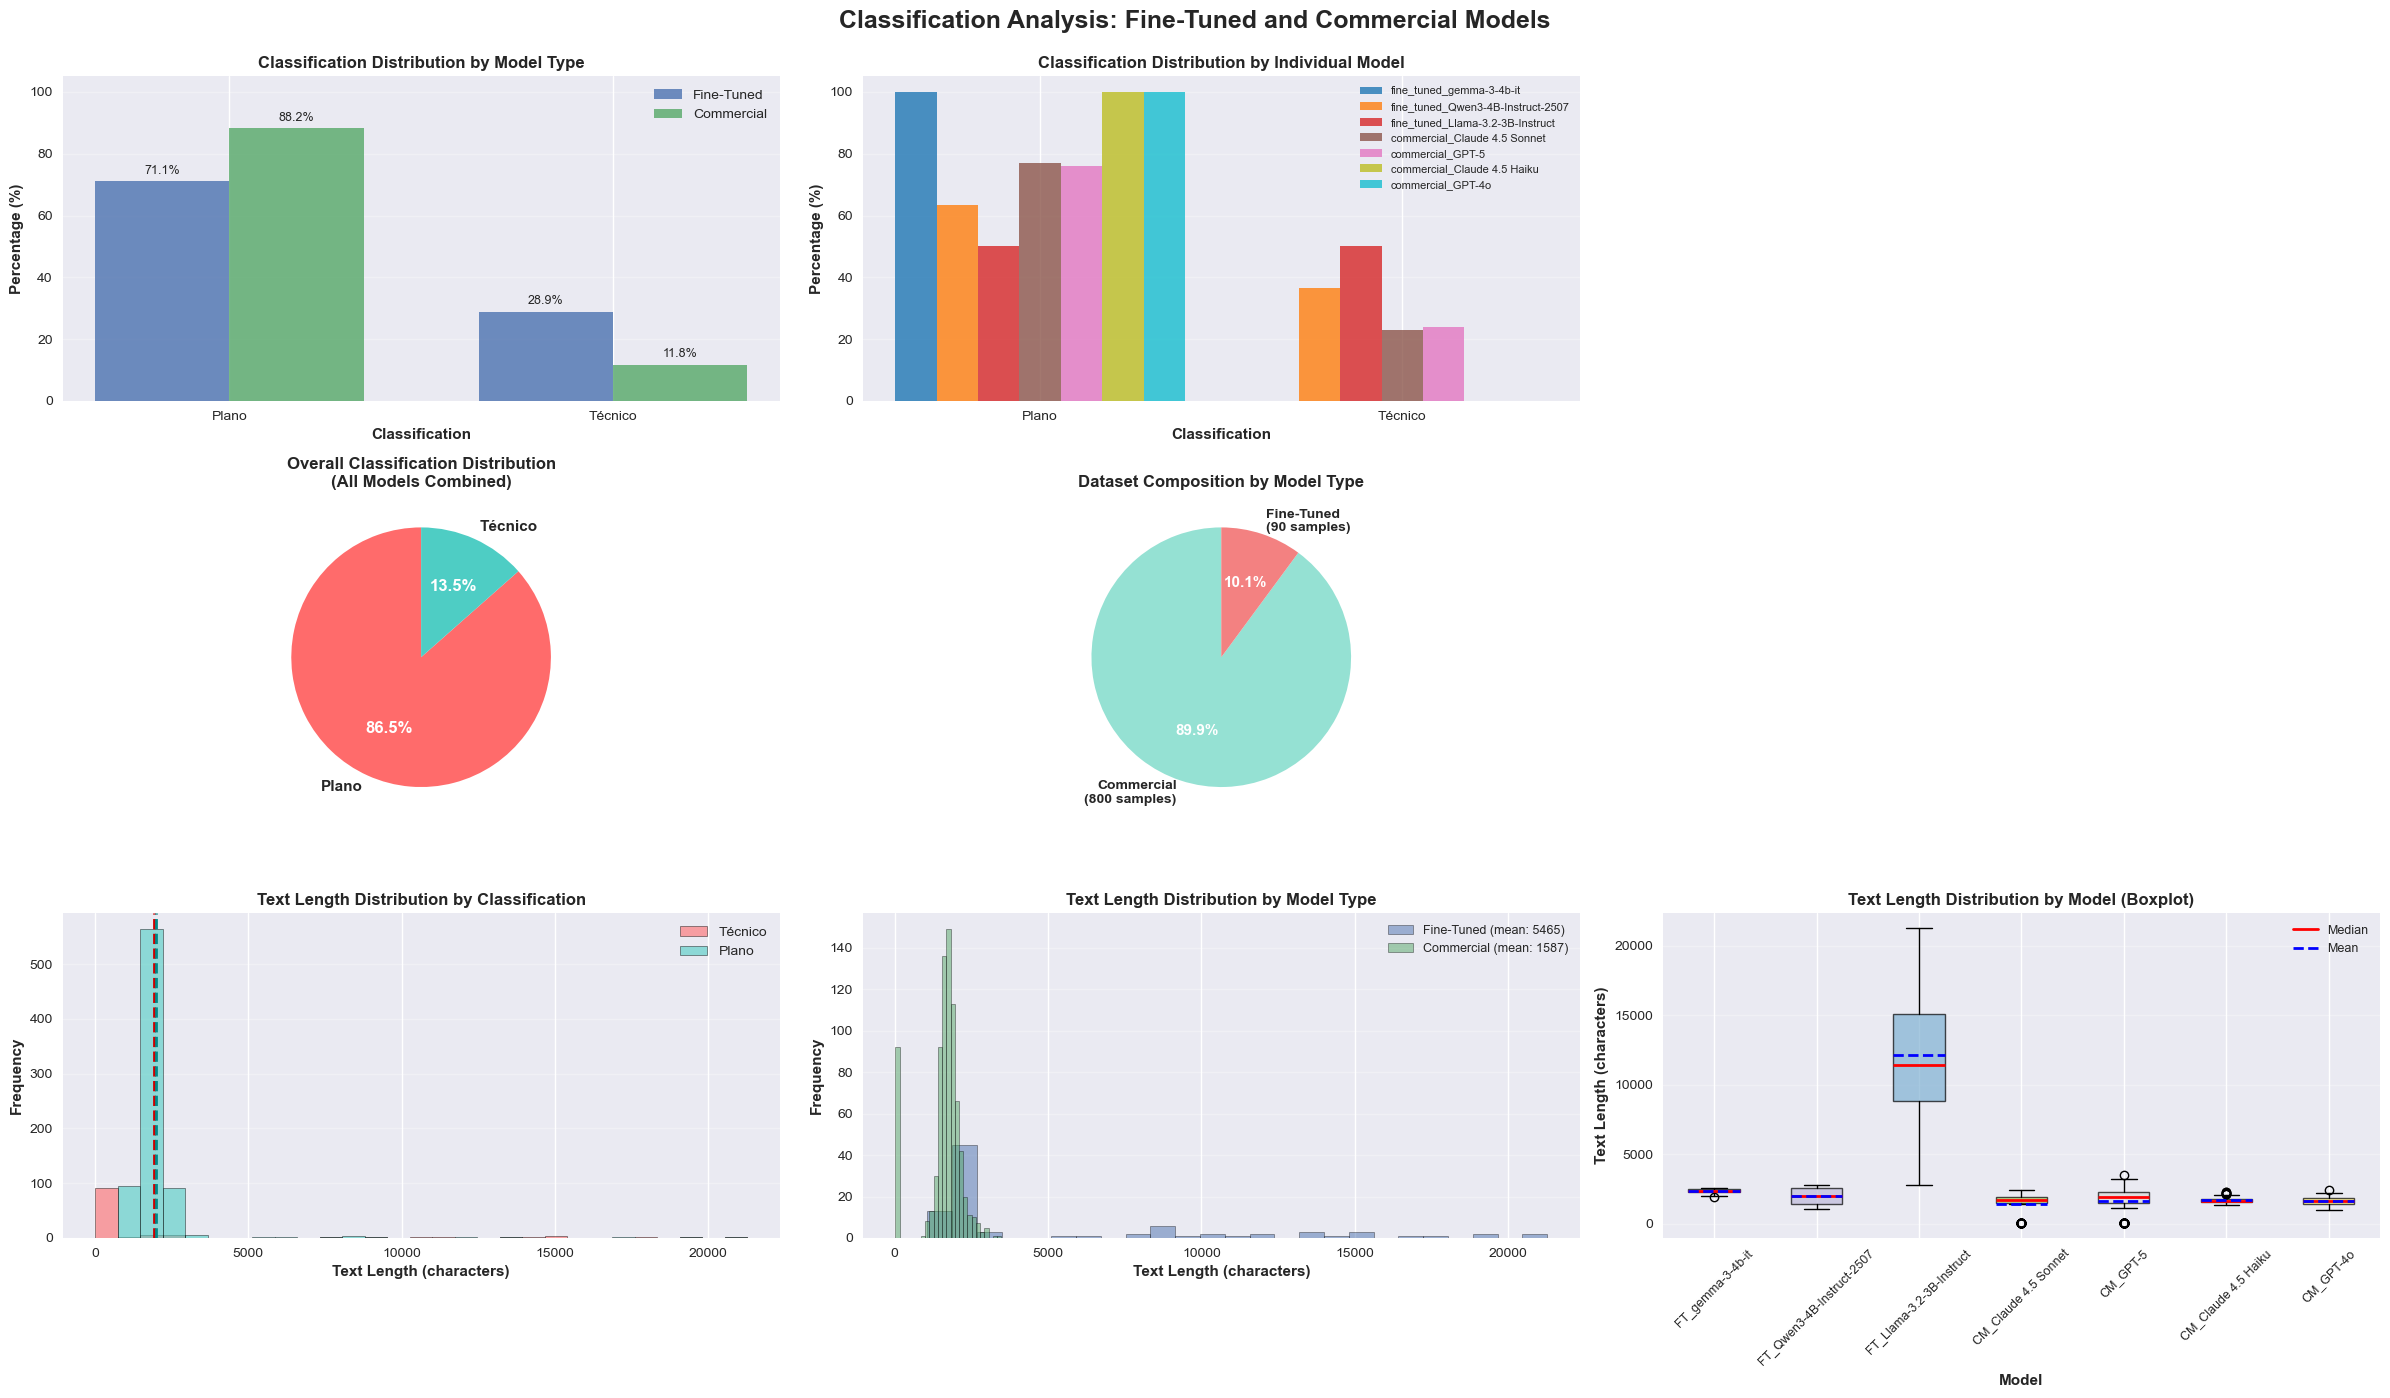


✅ Visualizations created successfully!

VISUALIZATION SUMMARY

📊 Total models analyzed: 7
   - Fine-tuned models: 3
   - Commercial models: 4

📝 Total predictions: 890
   - Plano: 770 (86.5%)
   - Técnico: 120 (13.5%)



In [36]:
# Enable inline plotting
%matplotlib inline

# Set up the plotting environment
from collections import Counter

plt.rcParams['figure.figsize'] = (12, 8)
plt.style.use('seaborn-v0_8')

# Ensure labeled_model_name column exists
if 'labeled_model_name' not in results_df.columns:
    def create_labeled_model_name(row):
        """Create labeled model name with type prefix"""
        model_id = row['model_identifier']
        model_type = row['model_type']
        
        # Extract short name from model identifier
        if '/' in model_id:
            short_name = model_id.split('/')[-1]
        else:
            short_name = model_id
        
        # Add prefix based on type
        if model_type == 'commercial':
            return f'commercial_{short_name}'
        else:  # fine-tuned
            return f'fine_tuned_{short_name}'
    
    results_df['labeled_model_name'] = results_df.apply(create_labeled_model_name, axis=1)
    print("✅ Created labeled_model_name column")

# Get unique models for plotting
unique_models = results_df.groupby('model_name').agg({
    'model_identifier': 'first',
    'model_type': 'first'
}).reset_index()

print("Creating visualizations...")

# Create comprehensive visualization with 7 plots
fig, axes = plt.subplots(3, 3, figsize=(24, 14))
fig.suptitle('Classification Analysis: Fine-Tuned and Commercial Models', fontsize=18, fontweight='bold', y=0.995)

# ========================================
# Plot 1: Classification Distribution by Model Type (Bar Chart - Percentages)
# ========================================
ax1 = axes[0, 0]

model_types = results_df['model_type'].unique()
classifications = sorted(results_df['prediction_label'].dropna().unique())

print(f"Model types: {model_types}")
print(f"Classifications: {classifications}")

# Prepare data for grouped bar chart
x = np.arange(len(classifications))
width = 0.35

for i, model_type in enumerate(model_types):
    type_data = results_df[results_df['model_type'] == model_type]
    percentages = []
    
    for classification in classifications:
        count = len(type_data[type_data['prediction_label'] == classification])
        total = len(type_data['prediction_label'].dropna())
        pct = (count / total * 100) if total > 0 else 0
        percentages.append(pct)
    
    ax1.bar(x + i*width - width/2, percentages, width, 
            label=model_type.title(), alpha=0.8)

ax1.set_xlabel('Classification', fontsize=11, fontweight='bold')
ax1.set_ylabel('Percentage (%)', fontsize=11, fontweight='bold')
ax1.set_title('Classification Distribution by Model Type', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(classifications)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_ylim(0, 105)

# Add percentage labels on bars
for i, model_type in enumerate(model_types):
    type_data = results_df[results_df['model_type'] == model_type]
    for j, classification in enumerate(classifications):
        count = len(type_data[type_data['prediction_label'] == classification])
        total = len(type_data['prediction_label'].dropna())
        pct = (count / total * 100) if total > 0 else 0
        if pct > 0:
            ax1.text(j + i*width - width/2, pct + 1.5, f'{pct:.1f}%', 
                    ha='center', va='bottom', fontsize=9)

# ========================================
# Plot 2: Classification Distribution by Individual Model (Bar Chart - Percentages)
# ========================================
ax2 = axes[0, 1]

model_names = results_df['labeled_model_name'].unique()
n_models = len(model_names)

print(f"Individual models: {model_names}")

x = np.arange(len(classifications))
width = 0.8 / n_models

colors = plt.cm.tab10(np.linspace(0, 1, n_models))

for i, labeled_name in enumerate(model_names):
    model_data = results_df[results_df['labeled_model_name'] == labeled_name]
    
    percentages = []
    for classification in classifications:
        count = len(model_data[model_data['prediction_label'] == classification])
        total = len(model_data['prediction_label'].dropna())
        pct = (count / total * 100) if total > 0 else 0
        percentages.append(pct)
    
    ax2.bar(x + i*width - width*(n_models-1)/2, percentages, width,
            label=labeled_name[:35], alpha=0.8, color=colors[i])

ax2.set_xlabel('Classification', fontsize=11, fontweight='bold')
ax2.set_ylabel('Percentage (%)', fontsize=11, fontweight='bold')
ax2.set_title('Classification Distribution by Individual Model', fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(classifications)
ax2.legend(fontsize=8, loc='upper right')
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_ylim(0, 105)

# ========================================
# Plot 3: Overall Distribution (Pie Chart)
# ========================================
ax3 = axes[1, 0]

all_predictions = results_df['prediction_label'].dropna()
if len(all_predictions) > 0:
    pred_counts = Counter(all_predictions)
    labels = list(pred_counts.keys())
    sizes = list(pred_counts.values())
    colors_pie = ['#ff6b6b', '#4ecdc4'] if len(labels) == 2 else plt.cm.Set3(np.linspace(0, 1, len(labels)))
    
    wedges, texts, autotexts = ax3.pie(sizes, labels=labels, autopct='%1.1f%%',
                                        startangle=90, colors=colors_pie,
                                        textprops={'fontsize': 11, 'fontweight': 'bold'})
    
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontsize(12)
        autotext.set_fontweight('bold')
    
    ax3.set_title('Overall Classification Distribution\n(All Models Combined)', 
                  fontsize=12, fontweight='bold')

# ========================================
# Plot 4: Model Type Composition (Pie Chart)
# ========================================
ax4 = axes[1, 1]

type_counts = results_df['model_type'].value_counts()
labels_pie = [f'{t.title()}\n({c} samples)' for t, c in zip(type_counts.index, type_counts.values)]
colors_pie = ['#95e1d3', '#f38181']

wedges, texts, autotexts = ax4.pie(type_counts.values, labels=labels_pie, 
                                     autopct='%1.1f%%', startangle=90,
                                     colors=colors_pie,
                                     textprops={'fontsize': 10, 'fontweight': 'bold'})

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(11)
    autotext.set_fontweight('bold')

ax4.set_title('Dataset Composition by Model Type', fontsize=12, fontweight='bold')

# ========================================
# Plot 5: Text Length Distribution by Classification (Histogram)
# ========================================
ax5 = axes[2, 0]

tech_lengths = []
plain_lengths = []

for _, row in results_df.iterrows():
    if pd.notna(row['prediction_label']) and pd.notna(row['generated_text']):
        text_length = len(str(row['generated_text']))
        if row['prediction_label'] == 'Técnico':
            tech_lengths.append(text_length)
        elif row['prediction_label'] == 'Plano':
            plain_lengths.append(text_length)

if tech_lengths and plain_lengths:
    bins = np.linspace(0, max(max(tech_lengths), max(plain_lengths)), 30)
    ax5.hist(tech_lengths, bins=bins, alpha=0.6, label='Técnico', 
            color='#ff6b6b', edgecolor='black', linewidth=0.5)
    ax5.hist(plain_lengths, bins=bins, alpha=0.6, label='Plano', 
            color='#4ecdc4', edgecolor='black', linewidth=0.5)
    
    ax5.set_xlabel('Text Length (characters)', fontsize=11, fontweight='bold')
    ax5.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax5.set_title('Text Length Distribution by Classification', fontsize=12, fontweight='bold')
    ax5.legend(fontsize=10)
    ax5.grid(True, alpha=0.3, axis='y')
    
    # Add mean lines
    ax5.axvline(np.mean(tech_lengths), color='#cc0000', linestyle='--', 
               linewidth=2)
    ax5.axvline(np.mean(plain_lengths), color='#008888', linestyle='--', 
               linewidth=2)
    
    print(f"Técnico mean length: {np.mean(tech_lengths):.0f}")
    print(f"Plano mean length: {np.mean(plain_lengths):.0f}")

# ========================================
# Plot 6: Text Length Distribution by Model Type (Histogram)
# ========================================
ax6 = axes[2, 1]

for model_type in results_df['model_type'].unique():
    type_data = results_df[results_df['model_type'] == model_type]
    lengths = []
    
    for _, row in type_data.iterrows():
        if pd.notna(row['prediction_label']) and pd.notna(row['generated_text']):
            lengths.append(len(str(row['generated_text'])))
    
    if lengths:
        ax6.hist(lengths, bins=25, alpha=0.5, label=f'{model_type.title()} (mean: {np.mean(lengths):.0f})',
                edgecolor='black', linewidth=0.5)

ax6.set_xlabel('Text Length (characters)', fontsize=11, fontweight='bold')
ax6.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax6.set_title('Text Length Distribution by Model Type', fontsize=12, fontweight='bold')
ax6.legend(fontsize=9)
ax6.grid(True, alpha=0.3, axis='y')

# ========================================
# Plot 7: Text Length Distribution by Model (Boxplot)
# ========================================
ax7 = axes[2, 2]

# Prepare data for boxplot
model_lengths = []
model_labels = []

for labeled_name in results_df['labeled_model_name'].unique():
    model_data = results_df[results_df['labeled_model_name'] == labeled_name]
    
    # Get text lengths for this model
    lengths = []
    for _, row in model_data.iterrows():
        if pd.notna(row['generated_text']):
            lengths.append(len(str(row['generated_text'])))
    
    if lengths:
        model_lengths.append(lengths)
        # Shorten labels for better display
        short_label = labeled_name.replace('fine_tuned_', 'FT_').replace('commercial_', 'CM_')
        model_labels.append(short_label[:25])

# Create boxplot
bp = ax7.boxplot(model_lengths, labels=model_labels, patch_artist=True, 
                  showmeans=True, meanline=True)

# Customize boxplot colors
colors = plt.cm.Set3(np.linspace(0, 1, len(model_lengths)))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Customize other elements
for element in ['whiskers', 'fliers', 'caps']:
    plt.setp(bp[element], color='black', linewidth=1)
plt.setp(bp['medians'], color='red', linewidth=2)
plt.setp(bp['means'], color='blue', linewidth=2, linestyle='--')

ax7.set_xlabel('Model', fontsize=11, fontweight='bold')
ax7.set_ylabel('Text Length (characters)', fontsize=11, fontweight='bold')
ax7.set_title('Text Length Distribution by Model (Boxplot)', fontsize=12, fontweight='bold')
ax7.tick_params(axis='x', rotation=45, labelsize=9)
ax7.grid(True, alpha=0.3, axis='y')

# Add legend for median and mean
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='red', linewidth=2, label='Median'),
    Line2D([0], [0], color='blue', linewidth=2, linestyle='--', label='Mean')
]
ax7.legend(handles=legend_elements, fontsize=9, loc='upper right')

print(f"\nBoxplot statistics:")
for i, (model_label, lengths) in enumerate(zip(model_labels, model_lengths)):
    print(f"{model_label}: median={np.median(lengths):.0f}, mean={np.mean(lengths):.0f}, std={np.std(lengths):.0f}")

# Hide unused subplots
axes[0, 2].axis('off')
axes[1, 2].axis('off')

# Adjust layout and display
plt.tight_layout()
plt.show()

print("\n✅ Visualizations created successfully!")

# Print summary statistics
print("\n" + "="*60)
print("VISUALIZATION SUMMARY")
print("="*60)

# Use labeled_model_name for summary
labeled_names = results_df['labeled_model_name'].unique()
print(f"\n📊 Total models analyzed: {len(labeled_names)}")
print(f"   - Fine-tuned models: {len([m for m in labeled_names if m.startswith('fine_tuned_')])}")
print(f"   - Commercial models: {len([m for m in labeled_names if m.startswith('commercial_')])}")

print(f"\n📝 Total predictions: {len(results_df['prediction_label'].dropna())}")
for classification in sorted(results_df['prediction_label'].dropna().unique()):
    count = len(results_df[results_df['prediction_label'] == classification])
    pct = (count / len(results_df['prediction_label'].dropna())) * 100
    print(f"   - {classification}: {count} ({pct:.1f}%)")

print("\n" + "="*60)

## Step 6: Detailed Statistical Analysis

In [24]:
# Detailed statistical analysis
from collections import Counter

print("📊 DETAILED STATISTICAL ANALYSIS")
print("=" * 50)

# 1. Basic statistics
print("\n1. BASIC STATISTICS:")
print("-" * 20)
total_valid_predictions = results_df['prediction_label'].notna().sum()
total_rows = len(results_df)
print(f"Total rows: {total_rows}")
print(f"Valid predictions: {total_valid_predictions} ({(total_valid_predictions/total_rows*100):.1f}%)")
print(f"Failed predictions: {total_rows - total_valid_predictions} ({((total_rows - total_valid_predictions)/total_rows*100):.1f}%)")

print("\nBy model type:")
for model_type in results_df['model_type'].unique():
    type_data = results_df[results_df['model_type'] == model_type]
    valid = type_data['prediction_label'].notna().sum()
    total_type = len(type_data)
    print(f"{model_type.upper()}: {valid} valid predictions out of {total_type} ({(valid/total_type*100):.1f}%)")

print("\nBy individual model:")
for model_name in results_df['model_name'].unique():
    model_data = results_df[results_df['model_name'] == model_name]
    valid = model_data['prediction_label'].notna().sum()
    total_model = len(model_data)
    model_id = model_data['model_identifier'].iloc[0] if len(model_data) > 0 else 'N/A'
    print(f"{model_name} ({model_id}): {valid}/{total_model} ({(valid/total_model*100):.1f}%)")

# 2. Classification distribution (PERCENTAGES)
print("\n2. CLASSIFICATION DISTRIBUTION (PERCENTAGES):")
print("-" * 30)

# Overall distribution
all_predictions = results_df['prediction_label'].dropna()
if len(all_predictions) > 0:
    pred_counts = Counter(all_predictions)
    total = len(all_predictions)
    print("Overall:")
    for label in sorted(pred_counts.keys()):
        count = pred_counts[label]
        percentage = (count / total) * 100
        print(f"  {label}: {percentage:.1f}%")

# By model type
for model_type in results_df['model_type'].unique():
    type_data = results_df[results_df['model_type'] == model_type]
    type_predictions = type_data['prediction_label'].dropna()
    
    if len(type_predictions) > 0:
        print(f"\n{model_type.upper()} Models:")
        type_counts = Counter(type_predictions)
        total_type_pred = len(type_predictions)
        for label in sorted(type_counts.keys()):
            count = type_counts[label]
            percentage = (count / total_type_pred) * 100
            print(f"  {label}: {percentage:.1f}%")

# Per individual model distribution
print("\nBy individual model:")
for labeled_name in results_df['labeled_model_name'].unique():
    model_data = results_df[results_df['labeled_model_name'] == labeled_name]
    model_predictions = model_data['prediction_label'].dropna()
    
    if len(model_predictions) > 0:
        print(f"\n{labeled_name}:")
        model_counts = Counter(model_predictions)
        total_model_pred = len(model_predictions)
        for label in sorted(model_counts.keys()):
            count = model_counts[label]
            percentage = (count / total_model_pred) * 100
            print(f"  {label}: {percentage:.1f}%")

# 3. Error analysis (PERCENTAGES)
print("\n3. ERROR ANALYSIS:")
print("-" * 15)
failed_requests = total_rows - total_valid_predictions
print(f"Total failed predictions: {failed_requests} ({(failed_requests/total_rows*100):.1f}%)")

for model_type in results_df['model_type'].unique():
    type_data = results_df[results_df['model_type'] == model_type]
    failed_count = type_data['prediction_label'].isna().sum()
    total_type = len(type_data)
    print(f"Failed predictions for {model_type}: {failed_count} ({(failed_count/total_type*100):.1f}%)")

if total_rows > 0:
    success_rate = (total_valid_predictions / total_rows) * 100
    print(f"Overall success rate: {success_rate:.1f}%")

# 4. Model comparison analysis
print("\n4. MODEL COMPARISON ANALYSIS:")
print("-" * 25)

# Compare fine-tuned vs commercial
fine_tuned_data = results_df[results_df['model_type'] == 'fine-tuned']
commercial_data = results_df[results_df['model_type'] == 'commercial']

if len(fine_tuned_data) > 0 and len(commercial_data) > 0:
    print("Fine-tuned vs Commercial models:")
    
    ft_predictions = fine_tuned_data['prediction_label'].dropna()
    cm_predictions = commercial_data['prediction_label'].dropna()
    
    if len(ft_predictions) > 0:
        ft_counts = Counter(ft_predictions)
        ft_total = len(ft_predictions)
        print(f"\nFine-tuned models ({ft_total} predictions):")
        for label in sorted(ft_counts.keys()):
            pct = (ft_counts[label] / ft_total) * 100
            print(f"  {label}: {pct:.1f}%")
    
    if len(cm_predictions) > 0:
        cm_counts = Counter(cm_predictions)
        cm_total = len(cm_predictions)
        print(f"\nCommercial models ({cm_total} predictions):")
        for label in sorted(cm_counts.keys()):
            pct = (cm_counts[label] / cm_total) * 100
            print(f"  {label}: {pct:.1f}%")

# 5. Text length analysis
print("\n5. TEXT LENGTH ANALYSIS:")
print("-" * 25)

for model_type in results_df['model_type'].unique():
    type_data = results_df[results_df['model_type'] == model_type]
    print(f"\n{model_type.upper()} Models:")
    
    for label in ['Técnico', 'Plano']:
        texts = type_data[type_data['prediction_label'] == label]['generated_text'].dropna()
        if len(texts) > 0:
            lengths = [len(str(text)) for text in texts]
            avg_length = np.mean(lengths)
            std_length = np.std(lengths)
            print(f"  {label}: avg length = {avg_length:.0f} ± {std_length:.0f} characters")
        else:
            print(f"  {label}: no data available")

# 6. Target Flesch-Kincaid Grade analysis (for fine-tuned models)
print("\n6. TARGET FLESCH-KINCAID GRADE ANALYSIS:")
print("-" * 40)

for model_name in ['gemma', 'qwen']:
    model_data = results_df[results_df['model_name'] == model_name]
    if 'target_fk_grade' in model_data.columns:
        fk_grades = model_data['target_fk_grade'].dropna()
        if len(fk_grades) > 0:
            print(f"\n{model_name.upper()}:")
            print(f"  Mean target FK grade: {fk_grades.mean():.2f}")
            print(f"  Std target FK grade: {fk_grades.std():.2f}")
            print(f"  Min: {fk_grades.min():.2f}, Max: {fk_grades.max():.2f}")

# 7. Summary statistics table
print("\n7. SUMMARY STATISTICS TABLE:")
print("-" * 80)
print(f"{'Model':<45} {'Type':<12} {'Total':<8} {'Técnico %':<12} {'Plano %':<10}")
print("-" * 80)

for labeled_name in results_df['labeled_model_name'].unique():
    model_data = results_df[results_df['labeled_model_name'] == labeled_name]
    model_type = model_data['model_type'].iloc[0] if len(model_data) > 0 else 'N/A'
    
    predictions = model_data['prediction_label'].dropna()
    total = len(predictions)
    
    if total > 0:
        counts = Counter(predictions)
        tech_pct = (counts.get('Técnico', 0) / total) * 100
        plain_pct = (counts.get('Plano', 0) / total) * 100
        
        print(f"{labeled_name:<45} {model_type:<12} {total:<8} {tech_pct:<12.1f} {plain_pct:<10.1f}")

📊 DETAILED STATISTICAL ANALYSIS

1. BASIC STATISTICS:
--------------------
Total rows: 890
Valid predictions: 890 (100.0%)
Failed predictions: 0 (0.0%)

By model type:
FINE-TUNED: 90 valid predictions out of 90 (100.0%)
COMMERCIAL: 800 valid predictions out of 800 (100.0%)

By individual model:
gemma (google/gemma-3-4b-it): 30/30 (100.0%)
qwen (Qwen/Qwen3-4B-Instruct-2507): 30/30 (100.0%)
ollama (meta-llama/Llama-3.2-3B-Instruct): 30/30 (100.0%)
generated_claude-sonnet-4-5 (Claude 3.5 Sonnet): 200/200 (100.0%)
generated_chatgpt-5 (GPT-5): 200/200 (100.0%)
claude-haiku-4-5 (Claude 3.5 Haiku): 200/200 (100.0%)
gpt-4o (GPT-4o): 200/200 (100.0%)

2. CLASSIFICATION DISTRIBUTION (PERCENTAGES):
------------------------------
Overall:
  Plano: 86.5%
  Técnico: 13.5%

FINE-TUNED Models:
  Plano: 71.1%
  Técnico: 28.9%

COMMERCIAL Models:
  Plano: 88.2%
  Técnico: 11.8%

By individual model:

gemma (google/gemma-3-4b-it):
  Plano: 100.0%

qwen (Qwen/Qwen3-4B-Instruct-2507):
  Plano: 63.3%
  Técn